In [145]:
""" This notebook performs backtest and performance analysis using optimzed hyperparameters
"""

' This notebook performs backtest and performance analysis using optimzed hyperparameters\n'

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import zscore
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

In [2]:
def backtest_full(data, return_data, all_features, num_features = 5, num_funds=50, month=1, look_back=3, delay=5 , positioning = True, redemption_cost = 0.001, K = 1 , position_pct = 0.8):
    """ Perform back test given different input parameters.
    :param data: contain asset feature data
    :param return_data: contain time series of asset total returns
    :param all_features: important features to consider
    :param num_features: number of features to use for fund selection each month
    :param month: rebalance frequency in months
    :param lookback: lookback months to compute the best sets of features
    :param delay: execution delays in days
    :param positioning: equal weight if set False, otherwise apply position sizing
    :param redemption_cost: percentage cost of fund redemption
    :param K: initial capital
    :param position_pct: percentage of K to invest for each month.
    return: A dataframe containg backtest statistics
    """

    selected_features_all = []
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = []
    selected_funds = []
    
    df_out = pd.DataFrame(index = dates[look_back:-1:month])
    profit = 0
    cash = K * (1 - position_pct)
    holding = K * position_pct
    
    for i, date in enumerate(dates[look_back:-1:month]):
        
        print(i, date)
        pnl_period = quantile_delayed(data[(data.statistic_date >= dates[i-look_back]) & (data.statistic_date < date)], return_data[(return_data.statistic_date >= dates[i-look_back]) & (return_data.statistic_date < date)], all_features, num_funds=5, month=1, delay=5)
        features = top_features(pnl_period, num_features)
        selected_features_all.append(features)
        col = features+['fund_id', 'ret']
        df = data[data.statistic_date == date][col].dropna()
        df['score'] = stats.zscore(df[features]).sum(axis=1)
        ret = 0
        df = df.sort_values(by='score', ascending=False)
        funds = list(df.fund_id[:num_funds])
        selected_funds.append(funds)
        
        if positioning:
            size = np.array([max(1/(i+1) - 1/50,0) if len(funds) > 0 else 1 for i in range(len(funds))])
            if len(size) > 0:
                size = 1 / sum(size) * size
            else:
                size = 1
        else:
            size = [1 / num_funds for i in range(num_fund)]
        
        temp_df = return_data[(return_data.statistic_date >= (dates[look_back::month][i] + pd.Timedelta(str(delay)+'d'))) & (return_data.statistic_date <= (dates[look_back::month][i+1]  + pd.Timedelta(str(delay)+'d')))]
        temp_df = temp_df.loc[temp_df['fund_id'].isin(funds)]
        temp_df = pd.pivot_table(data=temp_df,index=['statistic_date'],columns= ['fund_id'],values=['added_nav'])
    
        
        if temp_df.shape[0] > 0:
            temp_ret = ((size) / temp_df.iloc[0] * temp_df).sum(axis=1)
            cost = 0.015/10 + 0.015/ 12 + redemption_cost
            profit = holding * (temp_ret.iloc[-1] * (1-cost) - 1)
            temp_perf = performance_matrix(pd.DataFrame(temp_ret).pct_change(),['sharpe','volatility','max_drawdown','var'],annualized_factor=252).T
            df_out.loc[date,'sharpe'] = temp_perf['sharpe'].values[0]
            df_out.loc[date,'volatility'] =  temp_perf['volatility'].values[0]
            df_out.loc[date,'max_drawdown'] = temp_perf['max_drawdown'].values[0]
            df_out.loc[date,'var'] = temp_perf['var'].values[0]
        else:
            profit = 0
        pnl.append(profit)   
        
        df_out.loc[date,'cash'] = cash + profit
        df_out.loc[date,'funds'] = str(funds)
        df_out.loc[date,'features'] = str(features)
        df_out.loc[date,'profit'] = profit
        
    return df_out

In [3]:
def quantile_delayed(data, return_data, features, num_funds=50, month=1, delay=5):
    '''
    function that computes pnl over time for quantile trading with rebalancing every (t=month) months with delay
        
    inputs: data(pd dataframe), features(list), num_funds(integer) - number of
        funds we hold every month, month(integer) - number of month we are rebalancing
        for, delay (integer) - number of days it takes for us to buy funds
    output: a dict where keys are features and values are list of pnls over time
    '''
    
    dates = sorted(pd.to_datetime(data.statistic_date.unique()))
    pnl = {}
    for feature in features:
        pnl[feature] = []
        for date in dates[::month]:
            df = data[(data.statistic_date == date) & (data[feature].isna() == False)].sort_values(by=feature, ascending=False)
            ret = 0
            funds = df.fund_id[:num_funds]
            
            # Iterate through funds and calculate t - month look ahead return
            for fund in funds:
                ret_per_fund = 1
                for i in range(month):
                    month_ret = return_data[(return_data.statistic_date == (date + pd.DateOffset(months=i)+pd.Timedelta(str(delay)+'d'))) & (return_data.fund_id == fund)].ret.values
                    if month_ret.size > 0:
                        ret_per_fund *= (1 + month_ret[0]/num_funds)
                    else:
                        break
                ret += ret_per_fund-1
            pnl[feature].append(ret)
    return pnl

In [4]:
def load_data(filename):
    data = pickle.load(open(filename, "rb"))
    data.iloc[:,1:] = data.iloc[:,1:].apply(pd.to_numeric)
    data.statistic_date = pd.to_datetime(data.statistic_date)
    return data

In [5]:
# Sort features in terms of total cumulative pnl and pick top 20
def top_features(dic, top):
    cumul_pnl = {}
    for key, val in dic.items():
        cumul_pnl[key] = sum(val)
    
    sort_dic = dict(sorted(cumul_pnl.items(), key=lambda item: item[1]))
    return list(sort_dic.keys())[-top:]

In [144]:
def performance_matrix(df,metrics,annualized_factor = 12):
    """ Compute performance statistics of return series
    :param df: contain time series of percentage returns
    :param metrics: metrics to use for performance computation
    :param annualized_factor: 12 for montly and 252 for yearly
    return: A dataframe containg performance statistics
    """
    performance_matrix = []
    for metric in metrics:
        if metric == 'mean':
            performance_matrix.append(df.mean() * annualized_factor)
        elif metric == 'volatility':
            performance_matrix.append(df.std() * np.sqrt(annualized_factor))
        elif metric == 'sharpe':
            performance_matrix.append(df.mean() * annualized_factor / (df.std() * np.sqrt(annualized_factor)))
        elif metric == 'skew':
            performance_matrix.append(df.skew())
        elif metric == 'excess_kurtosis':
            performance_matrix.append(df.kurtosis() - 3)
        elif metric == 'var':
            performance_matrix.append(df.quantile(0.05))
        elif metric =='cvar':
            performance_matrix.append(df[df < df.quantile(0.05)].mean())
        elif metric =='max_drawdown':
            cum_returns = (1 + df).cumprod()
            rolling_max = cum_returns.cummax()
            drawdown = (cum_returns - rolling_max) / rolling_max
            performance_matrix.append(drawdown.min())
        else:
            raise NoSuchMetricError( 'Metric ' + metric + ' is not valid!')
            
    performance_matrix = pd.concat(performance_matrix,axis=1)
    performance_matrix.columns = metrics

    return performance_matrix.T

In [96]:
def volitility_scaling(x):
    x = abs(x)
    if x > 2:
        return 0.0
    elif x > 0.2:
        return 0.5
    else:
        return 1

### Load Data

In [84]:
data = load_data('data_new.pickle')
df_ret = pd.read_pickle('ret.pickle')
df_csi = pd.read_pickle('benchmark.pickle')
optimal_features = pd.read_pickle('rf_optimal_features_monthly.pickle')
dates = sorted(data.statistic_date.unique())

### Compute Most Common Features

In [85]:
opt = [np.array(optimal_features[i]) for i in range(len(optimal_features))]
ordered_feat = Counter(np.concatenate(opt,axis=0)).most_common()
most_common_feat = [x[0] for x in ordered_feat if x[1]>5]

In [86]:
most_common_feat_dict = dict([x for x in ordered_feat if x[1]>5])

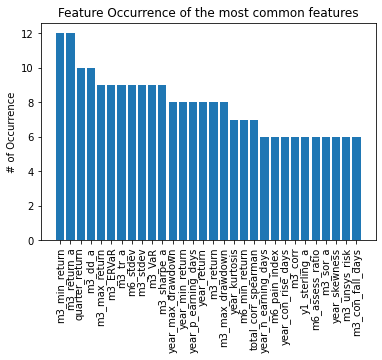

In [87]:

plt.bar(range(len(dict(most_common_feat_dict))), dict(most_common_feat_dict).values(), align='center')
plt.xticks(range(len(dict(most_common_feat_dict))), list(dict(most_common_feat_dict).keys()))
plt.xticks(rotation = 90)
plt.title('Feature Occurrence of the most common features')
plt.ylabel('# of Occurrence')
plt.show()

### Management Fee Distribution

In [53]:
data.fee.min(),data.fee.max()

(0.0015, 0.02)

(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  , 0.0225]),
 [Text(0.0, 0, '0.0000'),
  Text(0.0025, 0, '0.0025'),
  Text(0.005, 0, '0.0050'),
  Text(0.0075, 0, '0.0075'),
  Text(0.01, 0, '0.0100'),
  Text(0.0125, 0, '0.0125'),
  Text(0.015, 0, '0.0150'),
  Text(0.0175, 0, '0.0175'),
  Text(0.02, 0, '0.0200'),
  Text(0.0225, 0, '0.0225')])

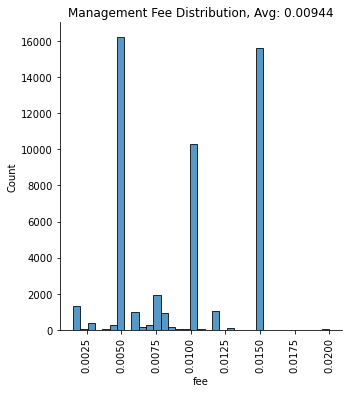

In [54]:
sns.displot(data.fee)
fee_avg = data.fee.mean()
plt.title('Management Fee Distribution, Avg: {fee}'.format(fee = round(fee_avg,5)))
plt.xticks(rotation = 90)

### Risk Management Analysis

In [11]:
best_params_saved = {'look_back': 3, 'delay': 3, 'num_funds': 4, 'num_features': 11}

In [12]:
%%time
df_out = backtest_full(data, df_ret,  most_common_feat,month =1, redemption_cost= 0.005, position_pct= 0.8, **best_params_saved )

0 2017-04-30 00:00:00
1 2017-05-31 00:00:00
2 2017-06-30 00:00:00
3 2017-07-31 00:00:00
4 2017-08-31 00:00:00
5 2017-09-30 00:00:00
6 2017-10-31 00:00:00
7 2017-11-30 00:00:00
8 2017-12-31 00:00:00
9 2018-01-31 00:00:00
10 2018-02-28 00:00:00
11 2018-03-31 00:00:00
12 2018-04-30 00:00:00
13 2018-05-31 00:00:00
14 2018-06-30 00:00:00
15 2018-07-31 00:00:00
16 2018-08-31 00:00:00
17 2018-09-30 00:00:00
18 2018-10-31 00:00:00
19 2018-11-30 00:00:00
20 2018-12-31 00:00:00
21 2019-01-31 00:00:00
22 2019-02-28 00:00:00
23 2019-03-31 00:00:00
24 2019-04-30 00:00:00
25 2019-05-31 00:00:00
26 2019-06-30 00:00:00
27 2019-07-31 00:00:00
28 2019-08-31 00:00:00
29 2019-09-30 00:00:00
30 2019-10-31 00:00:00
31 2019-11-30 00:00:00
32 2019-12-31 00:00:00
33 2020-01-31 00:00:00
34 2020-02-29 00:00:00
35 2020-03-31 00:00:00
36 2020-04-30 00:00:00
37 2020-05-31 00:00:00
38 2020-06-30 00:00:00
39 2020-07-31 00:00:00
40 2020-08-31 00:00:00
41 2020-09-30 00:00:00
42 2020-10-31 00:00:00
43 2020-11-30 00:00:0

In [13]:
df = df_out.iloc[:-1]

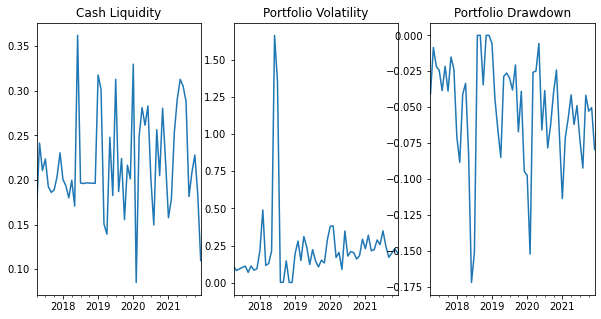

In [143]:

fig, ax =plt.subplots(1,3,figsize=(10,5))
df.cash.plot(ax = ax[0])
ax[0].title.set_text('Cash Liquidity')
df.volatility.plot(ax = ax[1])
ax[1].title.set_text('Portfolio Volatility')
df.max_drawdown.plot(ax = ax[2])
ax[2].title.set_text('Portfolio Drawdown')

In [17]:
def pnl_with_risk_management(df):
    pass

In [88]:
df.ret = df.profit.cumsum()
cum_returns = (df.ret + 1)/ (df.ret[0] + 1)
rolling_max = cum_returns.cummax()
df['drawdown_monthly'] = (cum_returns - rolling_max) / rolling_max

/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_22705/252688794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['drawdown_monthly'] = (cum_returns - rolling_max) / rolling_max


In [109]:
position = 1
out = df[[]]
max_drawdown_daily = -0.15
max_drawdown_monthly = -0.15

daily_drawdown = 0
monthly_drawdown = 0

vol_z = (df.volatility - df.volatility.rolling(3,min_periods = 1).median())/df.volatility.std()

for i, row in df.iterrows():
    out.loc[i,'position'] = position
    out.loc[i,'profit'] = row.profit
    pnl = row.profit * position
    out.loc[i,'vol_factor'] = volitility_scaling(vol_z[i])
    out.loc[i,'pnl_factor'] = 1 if row.cash > 0 else (1 + row.cash)
    
    out.loc[i,'daily_drawdown_factor'] = 1 if daily_drawdown < max_drawdown_daily  else 0
    out.loc[i,'monthly_drawdown_factor'] = 1 if monthly_drawdown < max_drawdown_monthly  else 0
    position = out.loc[i,'vol_factor'] * out.loc[i,'pnl_factor'] 
    
    daily_drawdown = row.max_drawdown
    monthly_drawdown = row.drawdown_monthly
    out.loc[i,'pnl'] = max_drawdown_daily if daily_drawdown < max_drawdown_daily else pnl
    out.loc[i,'pnl'] = max_drawdown_monthly if monthly_drawdown < max_drawdown_monthly else pnl

out.monthly_drawdown_factor = out.monthly_drawdown_factor.shift(-1)

/Users/charles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/charles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/charles/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentatio

In [110]:
out['commission'] = (1 + out['pnl']) * (0.015/12)

/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_22705/920923595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out['commission'] = (1 + out['pnl']) * (0.015/12)


In [111]:
ret_raw = (1 + out['profit'].cumsum())
ret_rm = (1 + out['pnl'].cumsum())
ret_raw_commission = (1 + (out['profit'] - out['commission']).cumsum())
ret_rm_commission =  (1 + (out['pnl'] - out['commission']).cumsum())

In [112]:
strategy_names = ['Raw Strategy','Raw Strategy with Commission','With Risk Management','With Risk Management and Commission']

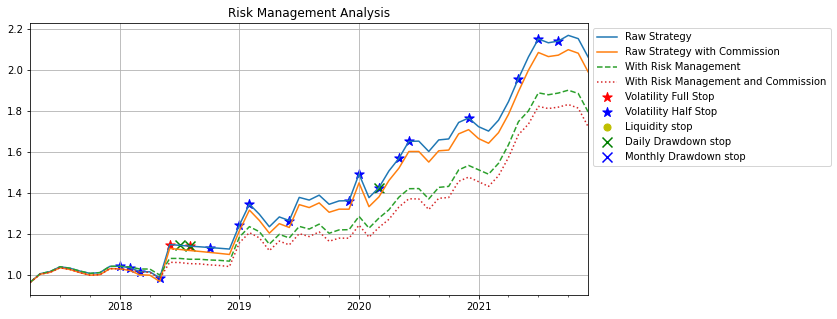

In [126]:
plt.subplots(figsize=(10,5))
ret_raw.plot(label= strategy_names[0])
ret_raw_commission.plot(label = strategy_names[1],linestyle = '-')
ret_rm.plot(label=strategy_names[2],linestyle = '--')
ret_rm_commission.plot(label =strategy_names[3],linestyle = ':')
vol_stop_full = out[out.vol_factor == 0]
vol_stop_half = out[out.vol_factor == 0.5]
liquid_stop = out[out.pnl_factor != 1]
daily_drawdown_stop = out[out.daily_drawdown_factor == 1]
monthly_drawdown_stop = out[out.monthly_drawdown_factor == 1]

plt.scatter(x=vol_stop_full.index, y=ret_raw[vol_stop_full.index],marker='*',color ='r',s = 100,label = 'Volatility Full Stop')
plt.scatter(x=vol_stop_half.index, y=ret_raw[vol_stop_half.index],marker='*',color ='b',s = 100,label = 'Volatility Half Stop')
plt.scatter(x=liquid_stop.index, y=ret_raw[liquid_stop.index],marker='.',color ='y',s = 200,label = 'Liquidity stop')
plt.scatter(x=daily_drawdown_stop.index, y=ret_raw[daily_drawdown_stop.index],marker='x',color ='g',s = 100,label = 'Daily Drawdown stop')
plt.scatter(x=monthly_drawdown_stop.index, y=ret_raw[monthly_drawdown_stop.index],marker='x',color ='b',s = 100,label = 'Monthly Drawdown stop')
plt.legend()
plt.title('Risk Management Analysis')
plt.grid()
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [114]:
metrics = ['mean','sharpe','max_drawdown','volatility','skew','excess_kurtosis','var','cvar']

In [115]:
df_perf = pd.concat([ret_raw,ret_raw_commission,ret_rm,ret_rm_commission],axis=1)
df_perf.columns = strategy_names

In [116]:
performance_matrix(df_perf.pct_change(),metrics = metrics).T

,mean,sharpe,max_drawdown,volatility,skew,excess_kurtosis,var,cvar
Raw Strategy,0.173740,1.200100,-0.081893,0.144771,1.021831,-0.837595,-0.038021,-0.055298
Raw Strategy with Commission,0.166761,1.124814,-0.085516,0.148256,1.000242,-0.947714,-0.039817,-0.057670
With Risk Management,0.139905,1.231846,-0.069182,0.113574,0.523492,-2.590493,-0.037944,-0.047607
With Risk Management and Commission,0.131643,1.127098,-0.072828,0.116798,0.514704,-2.634108,-0.040141,-0.050031


Text(0.5, 1.0, 'Strategy Position')

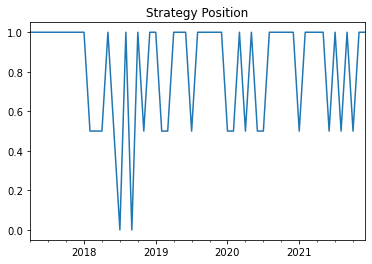

In [27]:
out.position.plot()
plt.title('Strategy Position')

### Benchmark Comparison

In [117]:
comparison = pd.DataFrame(index=ret_raw.index)
comparison['strategy'] = ret_rm_commission
comparison['benchmark'] = df_csi.Price 
comparison['benchmark'] = comparison['benchmark']/comparison['benchmark'].iloc[0]

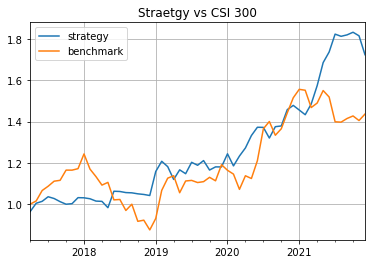

In [118]:
comparison.plot()
plt.title('Straetgy vs CSI 300')
plt.grid()
plt.show()

In [119]:
portfolios_performance = pd.DataFrame()
rhs = sm.add_constant(comparison['benchmark'].pct_change())
lhs = comparison['strategy'].pct_change()
res = sm.OLS(lhs,rhs,missing='drop').fit()
portfolios_performance.loc['Strategy', 'annualized alpha'] = res.params['const'] * 12
portfolios_performance.loc['Strategy', 'beta'] = res.params['benchmark']
portfolios_performance.loc['Strategy', '$R^2$'] = res.rsquared
portfolios_performance.loc['Strategy', 'information ratio'] = (res.params['const'] / res.resid.std()) * np.sqrt(12)

/Users/charles/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [120]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strategy   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.1162
Date:                Thu, 17 Mar 2022   Prob (F-statistic):              0.735
Time:                        20:56:25   Log-Likelihood:                 110.93
No. Observations:                  56   AIC:                            -217.9
Df Residuals:                      54   BIC:                            -213.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0112      0.005      2.439      0.018       0.002       0.020
benchmark     -0.0325      0.095     -0.341      0.735      -0.224       0.159
==============================================================================
Omnibus:                        3.555   Durbin-Watson:                   1.911
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                2.701
Skew:                           0.516   Prob(JB):                        0.259
Kurtosis:                       3.304   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
portfolios_performance

,annualized alpha,beta,$R^2$,information ratio
Strategy,0.134612,-0.032546,0.002147,1.153757


In [122]:
def bin_plot(comparison,n_bins = 5):
    """ generate bin plot by dividing benchmark return into quantiles and compare returns of the carry strategy 
     for each corresponding bins for the benchmark. It assesses comovement of returns bewtween carry PnL and 
     benchmark.
    :param df: contain time series of asset NAVs
    :return: Return distribution of carry PnL vs benchmark for each return bin
    """
    results, bin_edges = pd.qcut(comparison['benchmark'].pct_change(), q=n_bins,labels=[x for x in range(n_bins)],retbins= True)
    comparison['bin'] = results
    comparison['Strategy'] = comparison.strategy.pct_change()
    comparison['CSI 300'] =comparison.benchmark.pct_change()
    comparison.dropna().groupby('bin')['Strategy','CSI 300'].mean().plot(kind='bar')
    plt.title('Return Distribution of Strategy vs CSI 300')
    return bin_edges

/var/folders/sj/x531msr155b2cnd1db8frnr00000gn/T/ipykernel_22705/3316744108.py:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  comparison.dropna().groupby('bin')['Strategy','CSI 300'].mean().plot(kind='bar')


array([-0.08288793, -0.03110119,  0.0019026 ,  0.01544589,  0.04979272,
        0.14609433])

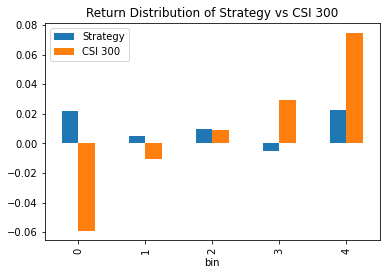

In [123]:
bin_plot(comparison)